In [1]:
# Standard code libraries
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
import resurfemg.preprocessing.envelope as evl

%matplotlib widget

In [31]:
# Define signal
fs_emg = 2048
t_emg = np.array([s_t/fs_emg for s_t in range(3*fs_emg)])
x_sin = np.sin((t_emg - 0.25) * 2 * np.pi)
x_sin[x_sin < 0] = 0
x_sin += 0.5
x_rand = np.random.normal(0, 1, size=len(x_sin))
x_t = x_sin * x_rand
# x_t = x_sin * x_rand + np.sqrt(0.5) * x_rand

In [32]:
def full_rolling_rms_original(data_emg, window_length):
    """This function computes a root mean squared envelope over an
    array :code:`data_emg`.  To do this it uses number of sample values
    :code:`window_length`. It differs from :func:`naive_rolling_rms`
    by that the     output is the same length as the input vector.

    :param data_emg: Samples from the EMG
    :type data_emg: ~numpy.ndarray
    :param window_length: Length of the sample use as window for function
    :type window_length: int

    :returns: The root-mean-squared EMG sample data
    :rtype: ~numpy.ndarray
    """
    x_pad = np.pad(
        data_emg,
        (0, window_length-1),
        'constant',
        constant_values=(0, 0)
    )

    x_2 = np.power(x_pad, 2)
    window = np.ones(window_length)/float(window_length)
    emg_rms = np.sqrt(np.convolve(x_2, window, 'valid'))
    return emg_rms

In [173]:
def full_rolling_rms_local(data_emg, window_length):
    """This function computes a root mean squared envelope over an
    array :code:`data_emg`.  To do this it uses number of sample values
    :code:`window_length`.

    :param data_emg: Samples from the EMG
    :type data_emg: ~numpy.ndarray
    :param window_length: Length of the sample use as window for function
    :type window_length: int

    :returns: The root-mean-squared EMG sample data
    :rtype: ~numpy.ndarray
    """
    padded_samples = int(np.floor(window_length/2))
    window = np.ones(window_length)/float(window_length)
    np.pad
    emg_rms_padded = np.sqrt(
        np.convolve(np.power(data_emg, 2), window, 'full'))
    
    start_correction = np.sqrt(
    window_length /(window_length - np.arange(window_length - 1, 0, -1)))
    emg_rms_padded[:len(start_correction)] *= start_correction
    end_correction = np.sqrt(
        window_length /(window_length - np.arange(1, window_length)))
    emg_rms_padded[-len(end_correction):] *= end_correction
    if len(emg_rms_padded) % 2 == 1 and len(data_emg) % 2 == 0:
        emg_rms = emg_rms_padded[padded_samples:-(padded_samples-1)]
    elif len(emg_rms_padded) % 2 == 0 and len(data_emg) % 2 == 1:
        emg_rms = emg_rms_padded[padded_samples:-(padded_samples-1)]
    else:
        emg_rms = emg_rms_padded[padded_samples:-padded_samples]

    return emg_rms

In [174]:
# Debug padding artifact
window_length = 6
padded_samples = int(np.floor(window_length/2))
window = np.ones(window_length)/float(window_length)

data_emg = np.ones((7, ))
# data_emg = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
a_pad = np.pad(a, padded_samples,'constant', constant_values=(np.NaN,))
emg_ms_padded = np.convolve(np.power(data_emg, 2), window, 'full')
emg_rms_padded = np.sqrt(
    np.convolve(np.power(data_emg, 2), window, 'full'))
start_correction = np.sqrt(
    window_length /(window_length - np.arange(window_length - 1, 0, -1)))
emg_rms_padded[:len(start_correction)] *= start_correction
end_correction = np.sqrt(
    window_length /(window_length - np.arange(1, window_length)))
emg_rms_padded[-len(end_correction):] *= end_correction
if len(emg_rms_padded) % 2 == 1 and len(data_emg) % 2 == 0:
    emg_rms = emg_rms_padded[padded_samples:-(padded_samples-1)]
elif len(emg_ms_padded) % 2 == 0 and len(data_emg) % 2 == 1:
    emg_rms = emg_rms_padded[padded_samples:-(padded_samples-1)]
else:
    emg_rms = emg_rms_padded[padded_samples:-padded_samples]



print(emg_rms)

[1. 1. 1. 1. 1. 1. 1.]


In [176]:
# Get RMS signal
window_s = fs_emg // 5  # 200 ms --> Delay of 100 ms
x_rms_original = full_rolling_rms_original(x_t, window_s)
# x_rms_new = evl.full_rolling_rms(x_t, window_s)
x_rms_new = full_rolling_rms_local(x_t, window_s)

# Find peaks in source, original RMS signal, and new RMS signal
peak_idxs_source, _ = find_peaks(x_sin, prominence=0.1)
peaks_original, _ = find_peaks(x_rms_original, prominence=0.1)
peaks_new, _ = find_peaks(x_rms_new, prominence=0.1)

# Check whether any peak errors are > 0.05 s
peak_errors = np.abs((t_emg[peaks_new] - t_emg[peak_idxs_source]))
np.any(peak_errors > 0.05)

False

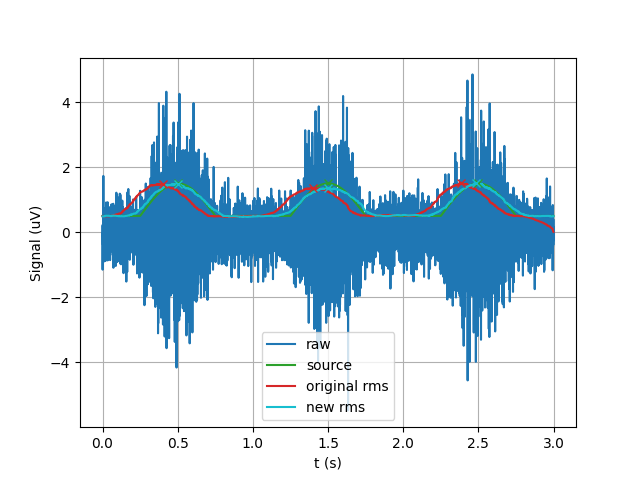

In [177]:
# Plot the raw data
fig, axis = plt.subplots(nrows=1, ncols=1)
axis.grid
axis.grid(True)
axis.plot(t_emg, x_t, color='tab:blue')
axis.plot(t_emg, x_sin, color='tab:green')
axis.plot(t_emg, x_rms_original, color='tab:red')
axis.plot(t_emg, x_rms_new, color='tab:cyan')
axis.plot(t_emg[peak_idxs_source], x_sin[peak_idxs_source], 'x', color='tab:green')
axis.plot(t_emg[peaks_original], x_rms_original[peaks_original],
          'x', color='tab:red')
axis.plot(t_emg[peaks_new], x_rms_new[peaks_new],
          'x', color='tab:cyan')
axis.set_xlabel('t (s)')
axis.set_ylabel('Signal (uV)')
axis.legend(['raw', 'source', 'original rms', 'new rms'])